# Rozpoznawanie gestów z akcelerometru – CNN-LSTM

In [67]:
!pip install torch torchvision torchaudio --quiet
!pip install scikit-learn seaborn --quiet

In [68]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Sprawdzenie dostępności GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Urządzenie treningowe: {device}')


Urządzenie treningowe: cuda


In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
import zipfile
from pathlib import Path

zip_path = '/content/drive/MyDrive/Colab Notebooks/data_ADXL345.zip'
image_path = ""

with zipfile.ZipFile(zip_path, "r") as zip_ref:
        print("Unzipping data...")
        zip_ref.extractall(image_path)

Unzipping data...


In [71]:
# 4. Parametry i lista gestów
DATA_FOLDER = '/content/data'
GESTURES = [
    "przesuniecie_w_prawo", "przesuniecie_w_lewo",
    "przesuniecie_w_gore", "przesuniecie_w_dol",
    "okrag_zgodnie_z_ruchem_wskazowek", "okrag_przeciwnie_do_ruchu_wskazowek",
    "litera_Z", "litera_V"
]
SEQUENCE_LENGTH = 80
OVERLAP_RATIO = 0.9
BATCH_SIZE = 32
LR = 1e-3
EPOCHS = 50


In [72]:
# 5. Przygotowanie Dataset
class GestureDataset(Dataset):
    def __init__(self, sequences, labels):
        self.X = torch.FloatTensor(sequences)
        self.y = torch.LongTensor(labels)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [73]:
# 6. Definicja modelu CNN-LSTM
class CNN_LSTM(nn.Module):
    def __init__(self, in_channels=3, hidden_size=64, n_classes=len(GESTURES)):
        super().__init__()
        # CNN
        self.conv1 = nn.Conv1d(in_channels, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm1d(64)
        self.pool  = nn.MaxPool1d(2)
        # LSTM
        self.lstm  = nn.LSTM(64, hidden_size, batch_first=True, dropout=0.2)
        # FC
        self.fc1   = nn.Linear(hidden_size, 32)
        self.dropout = nn.Dropout(0.3)
        self.fc2   = nn.Linear(32, n_classes)
        self.relu  = nn.ReLU()
    def forward(self, x):
        # x: (batch, seq_len, features) -> (batch, features, seq_len)
        x = x.transpose(1,2)
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        # (batch, features, seq) -> (batch, seq, features)
        x = x.transpose(1,2)
        # LSTM
        out, _ = self.lstm(x)
        last = out[:,-1,:]                  # ostatni krok
        x = self.relu(self.fc1(last))
        x = self.dropout(x)
        return self.fc2(x)


In [74]:
# 7. Funkcja ładowania i tworzenia sekwencji
def load_sequences(folder):
    scaler = StandardScaler()
    seqs, labs = [], []
    for idx, label in enumerate(GESTURES):
        files = [f for f in os.listdir(folder) if f.startswith(label) and f.endswith('.csv')]
        for fn in files:
            df = pd.read_csv(os.path.join(folder, fn))
            arr = df[['acc_x','acc_y','acc_z']].values
            if len(arr) < SEQUENCE_LENGTH: continue
            arr = scaler.fit_transform(arr)
            step = int(SEQUENCE_LENGTH * (1 - OVERLAP_RATIO))
            for start in range(0, len(arr)-SEQUENCE_LENGTH+1, step):
                seqs.append(arr[start:start+SEQUENCE_LENGTH])
                labs.append(idx)
    print(f'Utworzono {len(seqs)} sekwencji, rozkład gestów: {Counter(labs)}')
    return np.array(seqs), np.array(labs)

# Załaduj dane
X, y = load_sequences(DATA_FOLDER)


Utworzono 28928 sekwencji, rozkład gestów: Counter({2: 3644, 3: 3637, 4: 3635, 6: 3620, 0: 3618, 5: 3606, 7: 3603, 1: 3565})


In [75]:
# 8. Podział na zbiory i DataLoadery
dataset = GestureDataset(X, y)
n_train = int(0.8 * len(dataset))
n_val   = len(dataset) - n_train
train_ds, val_ds = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
print(f'Train: {len(train_ds)}, Val: {len(val_ds)}')


Train: 23142, Val: 5786


In [76]:
# 9. Inicjalizacja modelu, optymalizatora, funkcji straty
model = CNN_LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()


In [77]:
# 10. Pętla trenowania i walidacji
best_acc = 0
history = {'train_loss':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(1, EPOCHS+1):
    # trening
    model.train()
    tloss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        tloss += loss.item()
    # walidacja
    model.eval()
    vloss, correct, total = 0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            vloss += criterion(preds, yb).item()
            _, mx = preds.max(1)
            correct += (mx==yb).sum().item()
            total   += yb.size(0)
    # wyniki
    train_loss = tloss/len(train_loader)
    val_loss   = vloss/len(val_loader)
    val_acc    = correct/total*100
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
    print(f'E{epoch:02d}/{EPOCHS}  TrainLoss:{train_loss:.4f}  ValLoss:{val_loss:.4f}  ValAcc:{val_acc:.2f}%')


E01/50  TrainLoss:0.8648  ValLoss:0.3615  ValAcc:88.35%
E02/50  TrainLoss:0.4502  ValLoss:0.2765  ValAcc:91.12%
E03/50  TrainLoss:0.3706  ValLoss:0.2682  ValAcc:91.41%
E04/50  TrainLoss:0.3241  ValLoss:0.2602  ValAcc:91.00%
E05/50  TrainLoss:0.3017  ValLoss:0.2188  ValAcc:92.64%
E06/50  TrainLoss:0.2744  ValLoss:0.2052  ValAcc:92.84%
E07/50  TrainLoss:0.2635  ValLoss:0.1905  ValAcc:93.36%
E08/50  TrainLoss:0.2541  ValLoss:0.2052  ValAcc:93.05%
E09/50  TrainLoss:0.2370  ValLoss:0.1757  ValAcc:93.99%
E10/50  TrainLoss:0.2248  ValLoss:0.1965  ValAcc:93.69%
E11/50  TrainLoss:0.2194  ValLoss:0.1719  ValAcc:94.31%
E12/50  TrainLoss:0.2106  ValLoss:0.1675  ValAcc:94.26%
E13/50  TrainLoss:0.1978  ValLoss:0.1705  ValAcc:94.31%
E14/50  TrainLoss:0.1832  ValLoss:0.1376  ValAcc:95.40%
E15/50  TrainLoss:0.1949  ValLoss:0.1458  ValAcc:94.94%
E16/50  TrainLoss:0.1807  ValLoss:0.1598  ValAcc:94.75%
E17/50  TrainLoss:0.1832  ValLoss:0.1435  ValAcc:95.21%
E18/50  TrainLoss:0.1690  ValLoss:0.1283  ValAcc

In [78]:
# 11. Wczytanie najlepszego modelu i raport
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        out = model(xb).cpu()
        all_preds += out.argmax(1).tolist()
        all_trues += yb.tolist()
print(classification_report(all_trues, all_preds, target_names=GESTURES))


                                     precision    recall  f1-score   support

               przesuniecie_w_prawo       0.98      0.96      0.97       718
                przesuniecie_w_lewo       0.99      0.95      0.97       722
                przesuniecie_w_gore       0.97      1.00      0.98       776
                 przesuniecie_w_dol       0.98      0.99      0.99       724
   okrag_zgodnie_z_ruchem_wskazowek       0.94      0.94      0.94       733
okrag_przeciwnie_do_ruchu_wskazowek       0.93      0.95      0.94       685
                           litera_Z       0.99      0.99      0.99       742
                           litera_V       0.99      0.97      0.98       686

                           accuracy                           0.97      5786
                          macro avg       0.97      0.97      0.97      5786
                       weighted avg       0.97      0.97      0.97      5786



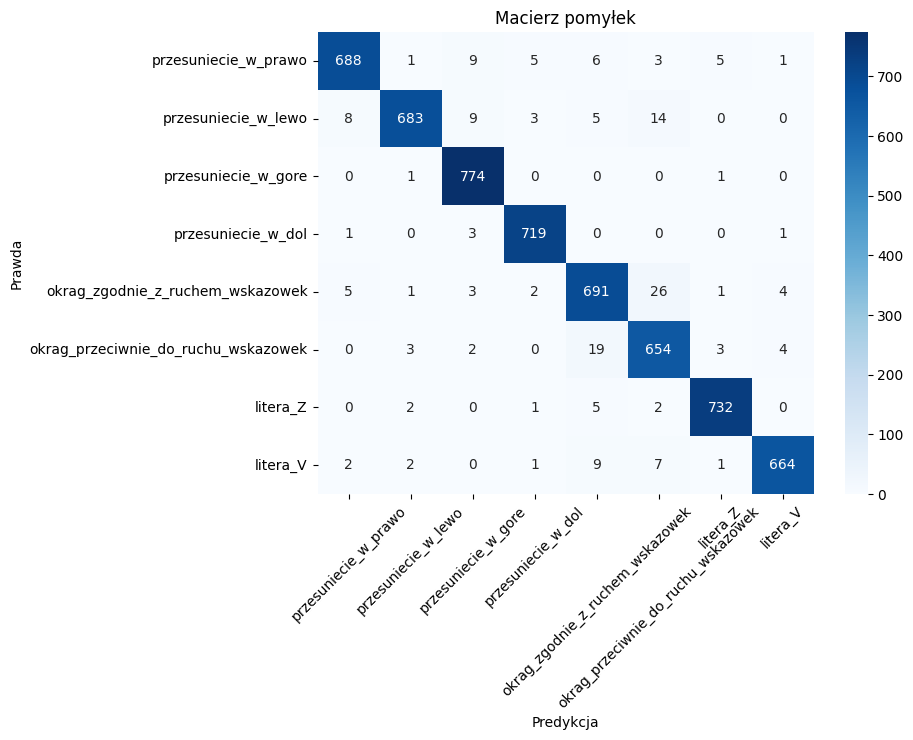

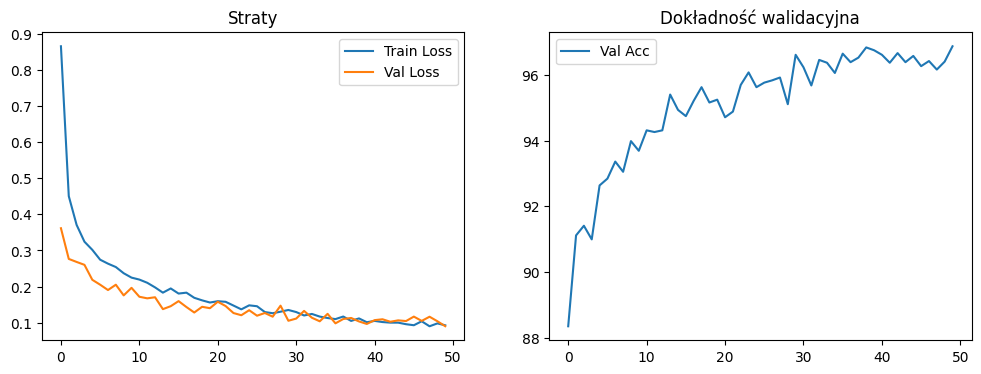

In [79]:
# 12. Wizualizacja: macierz pomyłek i historia trenowania
cm = confusion_matrix(all_trues, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=GESTURES, yticklabels=GESTURES, cmap='Blues')
plt.xlabel('Predykcja'); plt.ylabel('Prawda'); plt.title('Macierz pomyłek')
plt.xticks(rotation=45); plt.yticks(rotation=0)
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'],   label='Val Loss')
plt.legend(); plt.title('Straty')
plt.subplot(1,2,2)
plt.plot(history['val_acc'], label='Val Acc')
plt.legend(); plt.title('Dokładność walidacyjna')
plt.show()
